<a href="https://colab.research.google.com/github/HarshalPawar88/Book-Recommendation-System/blob/main/Book_Recommendation_System_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt


In [ ]:
df_books=pd.read_csv('/content/drive/MyDrive/Alma Better/Capstone_Project_2_BRS/data_book_recommendation/Books.csv')
df_ratings=pd.read_csv('/content/drive/MyDrive/Alma Better/Capstone_Project_2_BRS/data_book_recommendation/Ratings.csv')
df_users=pd.read_csv('/content/drive/MyDrive/Alma Better/Capstone_Project_2_BRS/data_book_recommendation/Users.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [ ]:
df_ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [ ]:
df_users.head(2)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [ ]:
s=[x for x in df_ratings['ISBN'].unique()]

In [ ]:
t=[x for x in df_books['ISBN'].unique()]

In [ ]:
#len([x for x in s if x not in t])

In [ ]:
print(df_books.shape)
print(df_ratings.shape)
print(df_users.shape)

(271360, 8)
(1149780, 3)
(278858, 3)


In [ ]:
len(df_ratings['ISBN'].unique())

340556

In [ ]:
len(df_ratings['ISBN'].unique())-len(df_books['ISBN'].unique())

69196

In [ ]:
len(df_books['ISBN'].unique())

271360

## **Unique Book Titles**

In [ ]:
len(df_books['Book-Title'].unique())

242135

### Shape of Unique Book-Title


In [ ]:
m=df_books.groupby(['Book-Title'])['ISBN'].count().reset_index()

In [ ]:
m.shape

(242135, 2)

### Books with more than one ISBN

In [ ]:
len(m[m['ISBN']>1].sort_values('Book-Title'))

19907

## **Unique ISBN**

In [ ]:
len(df_books['ISBN'].unique())

271360

## **Unique Combination of Book Title and ISBN**

In [ ]:
x=df_books.groupby(['Book-Title','ISBN']).size().reset_index()
x.shape

(271360, 3)

## **Unique Combination of Book Title and Year of Publication**

In [ ]:
x=df_books.groupby(['Book-Title','Year-Of-Publication']).size().reset_index()
x.shape

(268043, 3)

In [ ]:
#combinations greater than 1
len(x[x[0]>1].sort_values('Book-Title'))

3024

## **Book-Title  and Year of Publication Combination with ISBN count**

In [ ]:
n=df_books.groupby(['Book-Title','Year-Of-Publication'])['ISBN'].count().reset_index()
n.shape

(268043, 3)

## **Book-Title and Year of Publication combination Having More Than One ISBN**

In [ ]:
len(n[n['ISBN']>1])

3024

# Merging the Data

In [ ]:
merge_df=df_ratings.merge(df_books,how='inner',left_on='ISBN',right_on='ISBN').drop(columns=['Image-URL-S','Image-URL-M','Image-URL-L']).merge(df_users,how='left',left_on='User-ID',right_on='User-ID')

In [ ]:
merge_df.shape

(1031136, 9)

In [ ]:
merge_df.drop_duplicates(inplace=True)

In [ ]:
merge_df.shape

(1031136, 9)

# **Exploratory Data Analysis**

## 1.Distribution of Ratings

In [ ]:
rating_count=df_ratings['Book-Rating'].value_counts().reset_index().sort_values('Book-Rating',ascending=False)

In [ ]:
rating_count

,index,Book-Rating
0,0,716109
1,8,103736
2,10,78610
3,7,76457
4,9,67541
5,5,50974
6,6,36924
7,4,8904
8,3,5996
9,2,2759


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Ratings Count')

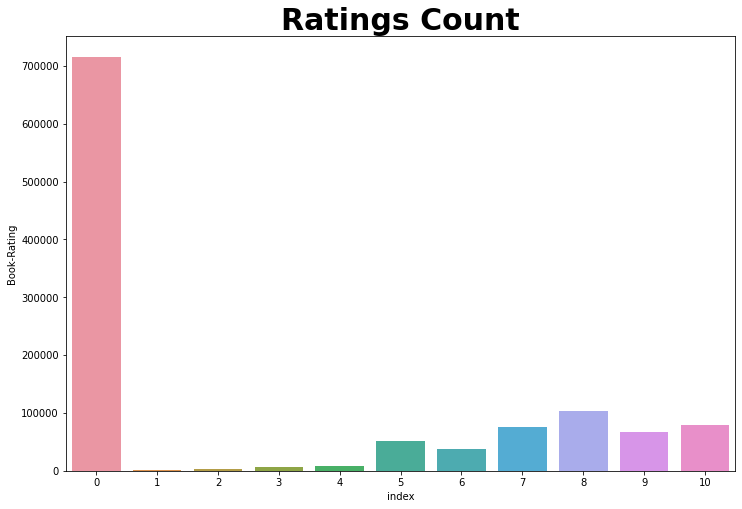

In [ ]:
plt.figure(figsize=(12,8))
ax=sns.barplot(rating_count['index'],rating_count['Book-Rating'])
ax.set_title('Ratings Count',fontsize=30,fontweight='bold')

In [ ]:
merge_df.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"cincinnati, ohio, usa",23.0


## Keeping Just the Country as Location

In [ ]:
merge_df['Location']=merge_df['Location'].apply(lambda x: "".join(x.split(',')[-1:]))

In [ ]:
merge_df.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,usa,NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,usa,23.0


### 2. Author vs Ratings

In [ ]:
len(merge_df['Book-Author'].unique())

101589

In [ ]:
auth_rating=merge_df.groupby(['Book-Author'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Author V/S Ratings')

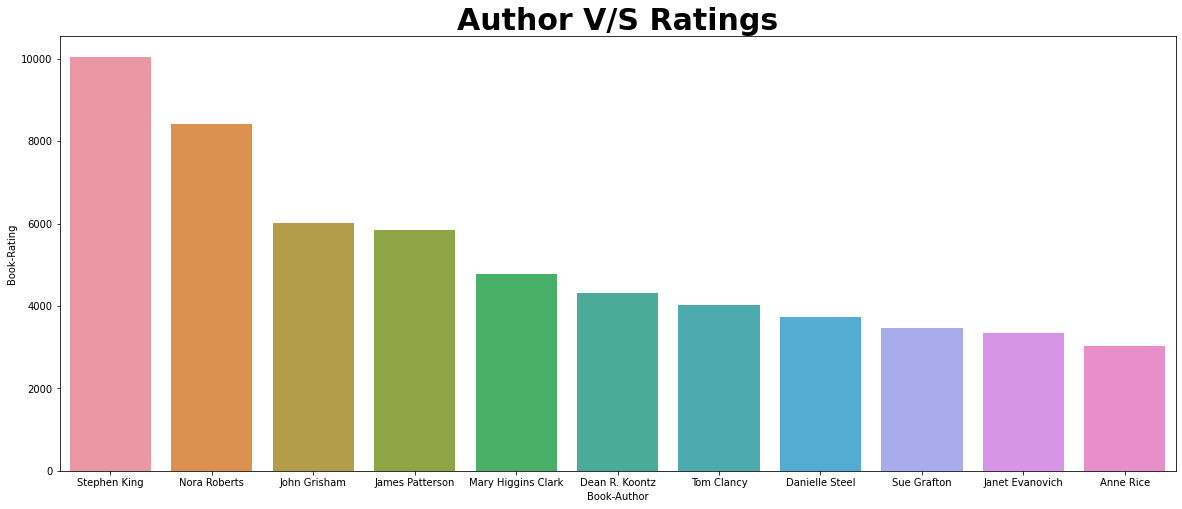

In [ ]:
plt.figure(figsize=(20,8))
ax=sns.barplot(auth_rating[auth_rating['Book-Rating']>3000]['Book-Author'],auth_rating[auth_rating['Book-Rating']>3000]['Book-Rating'])
ax.set_title('Author V/S Ratings', fontsize=30,fontweight='bold')


### 3.Book-Title V/S Ratings

In [ ]:
book_rating=merge_df.groupby(['Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

In [ ]:
book_rating[:10]

,Book-Title,Book-Rating
0,Wild Animus,2502
1,The Lovely Bones: A Novel,1295
2,The Da Vinci Code,898
3,A Painted House,838
4,The Nanny Diaries: A Novel,828
5,Bridget Jones's Diary,815
6,The Secret Life of Bees,774
7,Divine Secrets of the Ya-Ya Sisterhood: A Novel,740
8,The Red Tent (Bestselling Backlist),723
9,Angels &amp; Demons,670


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 7 Text major ticklabel objects>)

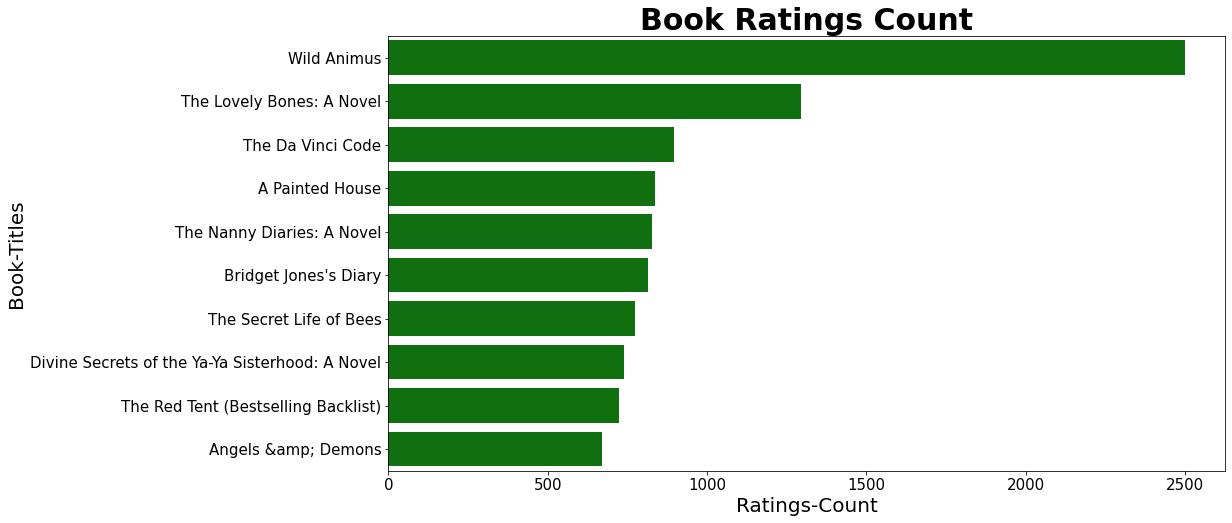

In [ ]:
plt.figure(figsize=(15,8))
ax=sns.barplot(book_rating['Book-Rating'][:10],book_rating['Book-Title'][:10],color='g')
ax.set_title('Book Ratings Count', fontsize=30,fontweight='bold')
ax.set_xlabel('Ratings-Count',fontsize=20)
ax.set_ylabel('Book-Titles',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

## Location Counts

In [ ]:
location_counts=merge_df.Location.value_counts().reset_index()

In [ ]:
[x for x in location_counts['index'][:10]]

[' usa',
 ' canada',
 ' united kingdom',
 ' germany',
 '',
 ' australia',
 ' spain',
 ' n/a',
 ' france',
 ' portugal']

In [ ]:
location_counts['index']=location_counts['index'].apply(lambda x:'Others' if x not in [x for x in location_counts['index'][:10]] else x)

In [ ]:
loc_count_group=location_counts.groupby(['index'])['Location'].sum().reset_index()


In [ ]:
pd.set_option('display.max_rows',288)

In [ ]:
#location_counts

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000., 800000.]), <a list of 9 Text major ticklabel objects>)

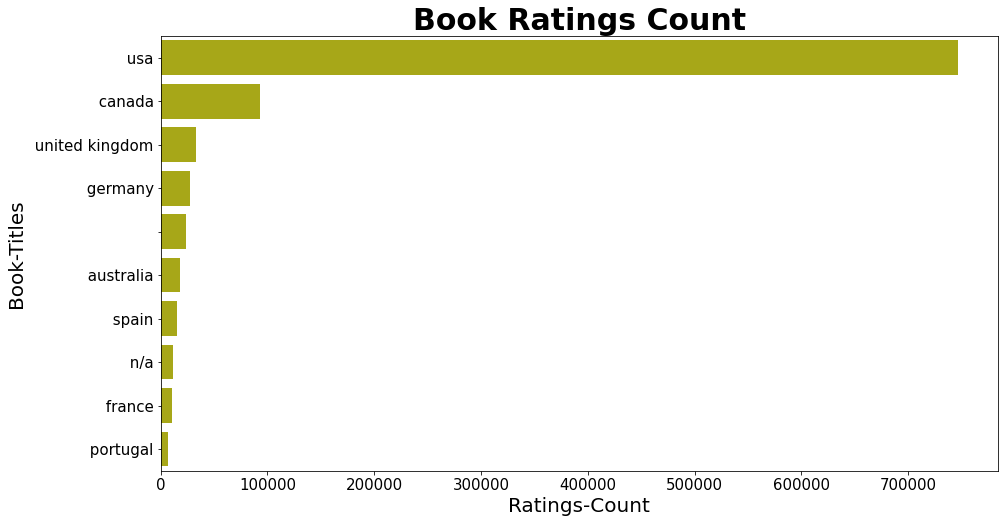

In [ ]:
plt.figure(figsize=(15,8))
ax=sns.barplot(location_counts['Location'][:10],location_counts['index'][:10],color='y')
ax.set_title('Book Ratings Count', fontsize=30,fontweight='bold')
ax.set_xlabel('Ratings-Count',fontsize=20)
ax.set_ylabel('Book-Titles',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

In [ ]:
df_ratings.shape

(1149780, 3)